<center><h1>Decision Trees and Random Forests</h1></center>

Dataset: (https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv)

In [1]:
# importing all necessary libraries
import warnings
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

warnings.filterwarnings('ignore')

In [2]:
# Download the dataset
import urllib.request

url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (9704, 11)


,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [3]:
# Check for missing values
print(df.isnull().sum())

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64


In [4]:
# Data preparation
df = df.fillna(0)

# Separate features and target
y = df['fuel_efficiency_mpg'].values
del df['fuel_efficiency_mpg']

# Train/validation/test split: 60%/20%/20%
df_train_full, df_test, y_train_full, y_test = train_test_split(
    df, y, test_size=0.2, random_state=1
)

df_train, df_val, y_train, y_val = train_test_split(
    df_train_full, y_train_full, test_size=0.25, random_state=1
)

print(f"Training set: {df_train.shape}")
print(f"Validation set: {df_val.shape}")
print(f"Test set: {df_test.shape}")

Training set: (5822, 10)
Validation set: (1941, 10)
Test set: (1941, 10)


In [5]:
# Use DictVectorizer to turn dataframes into matrices
dv = DictVectorizer(sparse=True)

# Convert to dictionaries
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

# Transform
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

print(f"Feature matrix shape - Training: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
print(f"Feature names: {dv.get_feature_names_out()}")

Feature matrix shape - Training: (5822, 14), Validation: (1941, 14), Test: (1941, 14)
Feature names: ['acceleration' 'drivetrain=All-wheel drive'
 'drivetrain=Front-wheel drive' 'engine_displacement' 'fuel_type=Diesel'
 'fuel_type=Gasoline' 'horsepower' 'model_year' 'num_cylinders'
 'num_doors' 'origin=Asia' 'origin=Europe' 'origin=USA' 'vehicle_weight']


## Question 1:

In [6]:
# Train decision tree with max_depth=1
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train, y_train)

# Get feature names
feature_names = dv.get_feature_names_out()

# Find the feature used for splitting (first split)
tree = dt.tree_
feature_used = tree.feature[0]
feature_name = feature_names[feature_used]

print(f"Feature used for splitting: {feature_name}")
print(f"\nDecision tree structure:")
print(f"Root node uses feature: {feature_name}")
print(f"Threshold: {tree.threshold[0]:.4f}")
print(f"Number of samples in root: {tree.n_node_samples[0]}")

Feature used for splitting: vehicle_weight

Decision tree structure:
Root node uses feature: vehicle_weight
Threshold: 3022.1073
Number of samples in root: 5822


In [7]:
# Visualize the tree structure more clearly
from sklearn.tree import export_text

tree_rules = export_text(dt, feature_names=list(feature_names), max_depth=1)
print("Decision Tree Rules:")
print(tree_rules)

Decision Tree Rules:
|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



## Question 2

In [8]:
# Train random forest with n_estimators=10
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict on validation set
y_pred = rf.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"RMSE on validation data: {rmse:.4f}")
print(f"\nPrediction statistics:")
print(f"Mean predicted value: {y_pred.mean():.4f}")
print(f"Mean actual value: {y_val.mean():.4f}")

RMSE on validation data: 0.4596

Prediction statistics:
Mean predicted value: 14.9511
Mean actual value: 14.9539


## Question 3

In [9]:
# Try different values of n_estimators from 10 to 200 with step 10
n_estimators_range = range(10, 201, 10)
rmse_scores = []

for n_est in n_estimators_range:
    rf = RandomForestRegressor(n_estimators=n_est, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    
    if n_est % 50 == 0 or n_est <= 30:
        print(f"n_estimators={n_est:3d}, RMSE={rmse:.6f}")

# Find where RMSE stops improving (considering 3 decimal places)
rmse_rounded = [round(r, 3) for r in rmse_scores]
improvement_stopped = False
stopped_at = None

for i in range(1, len(rmse_rounded)):
    if rmse_rounded[i] >= rmse_rounded[i-1]:
        if not improvement_stopped:
            stopped_at = n_estimators_range[i]
            improvement_stopped = True
    else:
        improvement_stopped = False
        stopped_at = None

if stopped_at is None:
    stopped_at = n_estimators_range[-1]
    
print(f"\nRMSE stops improving after n_estimators = {stopped_at}")

n_estimators= 10, RMSE=0.459578
n_estimators= 20, RMSE=0.453591
n_estimators= 30, RMSE=0.451687
n_estimators= 50, RMSE=0.446657
n_estimators=100, RMSE=0.444652
n_estimators=150, RMSE=0.442898
n_estimators=200, RMSE=0.442479

RMSE stops improving after n_estimators = 190


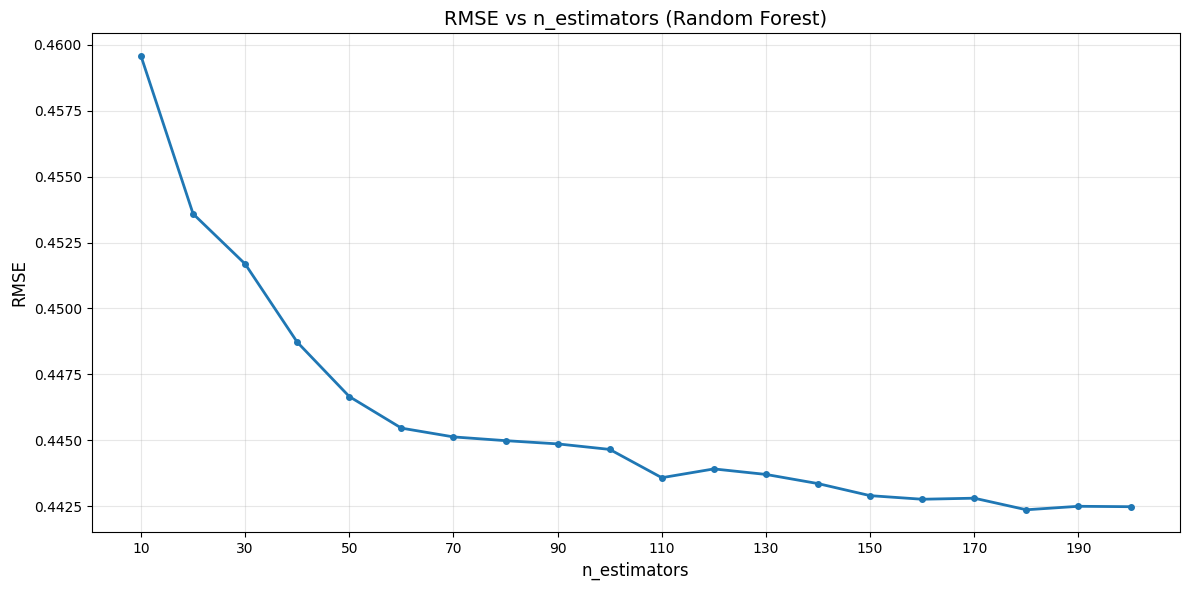


Detailed RMSE values (rounded to 3 decimal places):
n_estimators= 10, RMSE=0.459578 (0.460)
n_estimators= 20, RMSE=0.453591 (0.454)
n_estimators= 30, RMSE=0.451687 (0.452)
n_estimators= 40, RMSE=0.448721 (0.449)
n_estimators= 60, RMSE=0.445460 (0.445)
n_estimators= 80, RMSE=0.444984 (0.445)
n_estimators=100, RMSE=0.444652 (0.445)
n_estimators=120, RMSE=0.443912 (0.444)
n_estimators=140, RMSE=0.443355 (0.443)
n_estimators=160, RMSE=0.442761 (0.443)
n_estimators=180, RMSE=0.442362 (0.442)
n_estimators=200, RMSE=0.442479 (0.442)


In [10]:
# Visualize the RMSE values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(list(n_estimators_range), rmse_scores, marker='o', linewidth=2, markersize=4)
plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('RMSE vs n_estimators (Random Forest)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(10, 201, 20))
plt.tight_layout()
plt.show()

# Show detailed results for key values
print("\nDetailed RMSE values (rounded to 3 decimal places):")
for i, (n_est, rmse) in enumerate(zip(n_estimators_range, rmse_scores)):
    if n_est % 20 == 0 or n_est <= 30:
        print(f"n_estimators={n_est:3d}, RMSE={rmse:.6f} ({rmse_rounded[i]:.3f})")

In [11]:
# Find the last value where we see improvement (rounded to 3 decimal places)
last_improvement = None
for i in range(1, len(rmse_rounded)):
    prev_rmse = rmse_rounded[i-1]
    curr_rmse = rmse_rounded[i]
    
    if curr_rmse < prev_rmse:
        # Improvement found
        last_improvement = n_estimators_range[i]
        print(f"✓ n_estimators={n_estimators_range[i]:3d}: RMSE improved from {prev_rmse:.3f} to {curr_rmse:.3f}")
    else:
        # No improvement or got worse
        if curr_rmse > prev_rmse:
            print(f"✗ n_estimators={n_estimators_range[i]:3d}: RMSE worsened from {prev_rmse:.3f} to {curr_rmse:.3f}")
        else:
            print(f"= n_estimators={n_estimators_range[i]:3d}: RMSE stayed at {curr_rmse:.3f}")

if last_improvement is None:
    # If never improved, use the first value
    last_improvement = n_estimators_range[0]
    print(f"\nNote: RMSE never improved, using first value")

print(f"\n" + "="*60)
print(f"Answer: RMSE stops improving after n_estimators = {last_improvement}")
print(f"This means the last improvement occurred at n_estimators = {last_improvement}")
print("="*60)

✓ n_estimators= 20: RMSE improved from 0.460 to 0.454
✓ n_estimators= 30: RMSE improved from 0.454 to 0.452
✓ n_estimators= 40: RMSE improved from 0.452 to 0.449
✓ n_estimators= 50: RMSE improved from 0.449 to 0.447
✓ n_estimators= 60: RMSE improved from 0.447 to 0.445
= n_estimators= 70: RMSE stayed at 0.445
= n_estimators= 80: RMSE stayed at 0.445
= n_estimators= 90: RMSE stayed at 0.445
= n_estimators=100: RMSE stayed at 0.445
✓ n_estimators=110: RMSE improved from 0.445 to 0.444
= n_estimators=120: RMSE stayed at 0.444
= n_estimators=130: RMSE stayed at 0.444
✓ n_estimators=140: RMSE improved from 0.444 to 0.443
= n_estimators=150: RMSE stayed at 0.443
= n_estimators=160: RMSE stayed at 0.443
= n_estimators=170: RMSE stayed at 0.443
✓ n_estimators=180: RMSE improved from 0.443 to 0.442
= n_estimators=190: RMSE stayed at 0.442
= n_estimators=200: RMSE stayed at 0.442

Answer: RMSE stops improving after n_estimators = 180
This means the last improvement occurred at n_estimators = 180

## Question 4


Testing max_depth=10
Mean RMSE for max_depth=10: 0.441808

Testing max_depth=15
Mean RMSE for max_depth=15: 0.445417

Testing max_depth=20
Mean RMSE for max_depth=20: 0.446253

Testing max_depth=25
Mean RMSE for max_depth=25: 0.445910


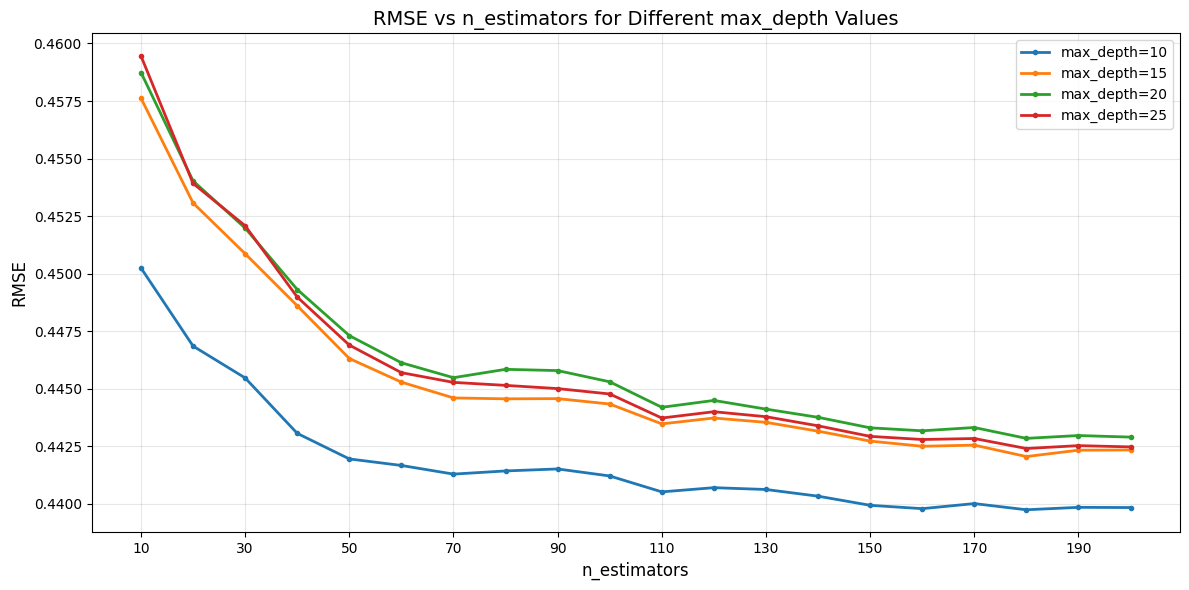


Summary of Mean RMSE for each max_depth:
max_depth=10: Mean RMSE = 0.441808
max_depth=15: Mean RMSE = 0.445417
max_depth=20: Mean RMSE = 0.446253
max_depth=25: Mean RMSE = 0.445910

Best max_depth: 10 (Mean RMSE = 0.441808)


In [12]:
# Try different max_depth values
max_depth_values = [10, 15, 20, 25]
n_estimators_range = range(10, 201, 10)

plt.figure(figsize=(12, 6))
results = {}

for max_d in max_depth_values:
    rmse_scores = []
    print(f"\nTesting max_depth={max_d}")
    
    for n_est in n_estimators_range:
        rf = RandomForestRegressor(
            n_estimators=n_est, 
            max_depth=max_d, 
            random_state=1, 
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    mean_rmse = np.mean(rmse_scores)
    results[max_d] = mean_rmse
    print(f"Mean RMSE for max_depth={max_d}: {mean_rmse:.6f}")
    plt.plot(list(n_estimators_range), rmse_scores, marker='o', label=f'max_depth={max_d}', linewidth=2, markersize=3)

plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('RMSE vs n_estimators for Different max_depth Values', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(10, 201, 20))
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Summary of Mean RMSE for each max_depth:")
for max_d, mean_rmse in sorted(results.items()):
    print(f"max_depth={max_d:2d}: Mean RMSE = {mean_rmse:.6f}")

best_max_depth = min(results, key=results.get)
print(f"\nBest max_depth: {best_max_depth} (Mean RMSE = {results[best_max_depth]:.6f})")

## Question 5

In [13]:
# Train the model with specified parameters
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Get feature importances
feature_names = dv.get_feature_names_out()
feature_importances = rf.feature_importances_

# Create a dataframe for easier viewing
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("Feature Importances:")
print("=" * 60)
print(importance_df.to_string(index=False))
print("=" * 60)

# Find the most important feature
most_important_feature = importance_df.iloc[0]['feature']
most_important_value = importance_df.iloc[0]['importance']

print(f"\nMost important feature: {most_important_feature}")
print(f"Importance value: {most_important_value:.6f}")

Feature Importances:
                     feature  importance
              vehicle_weight    0.959150
                  horsepower    0.015998
                acceleration    0.011480
         engine_displacement    0.003273
                  model_year    0.003212
               num_cylinders    0.002343
                   num_doors    0.001635
                  origin=USA    0.000540
               origin=Europe    0.000519
                 origin=Asia    0.000462
          fuel_type=Gasoline    0.000360
  drivetrain=All-wheel drive    0.000357
drivetrain=Front-wheel drive    0.000345
            fuel_type=Diesel    0.000325

Most important feature: vehicle_weight
Importance value: 0.959150


In [14]:
# Check the specific features mentioned in the question
features_to_check = ['vehicle_weight', 'horsepower', 'acceleration', 'engine_displacement']

print("\nImportance of specific features mentioned in Question 5:")
print("-" * 60)
for feature in features_to_check:
    # Find matching feature name (could be exact or with prefix)
    matching_features = [f for f in feature_names if feature in f.lower()]
    if matching_features:
        for f in matching_features:
            idx = list(feature_names).index(f)
            print(f"{f:30s}: {feature_importances[idx]:.6f}")
    else:
        print(f"{feature:30s}: Not found")


Importance of specific features mentioned in Question 5:
------------------------------------------------------------
vehicle_weight                : 0.959150
horsepower                    : 0.015998
acceleration                  : 0.011480
engine_displacement           : 0.003273


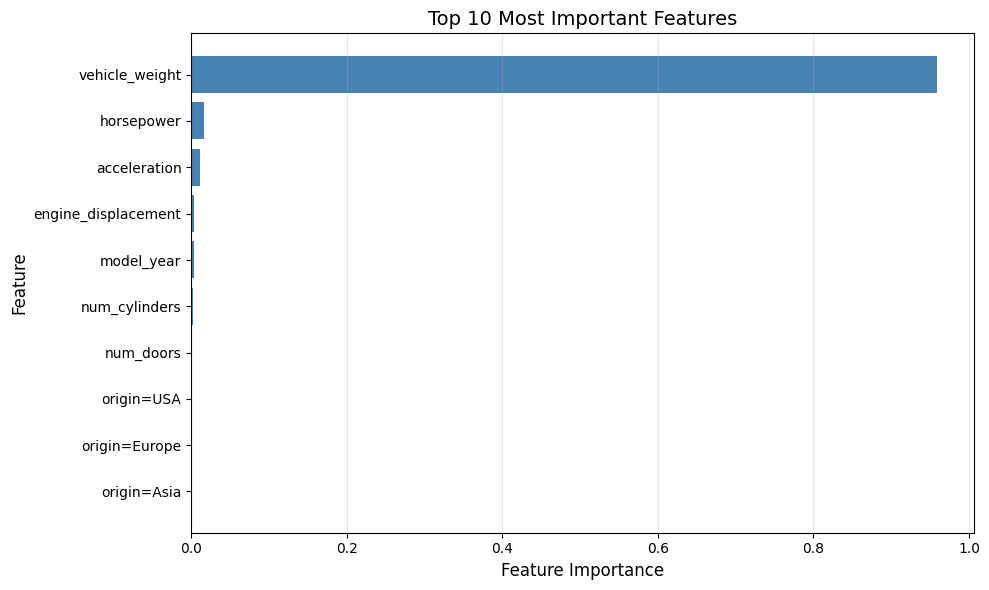

In [15]:
# Visualize top 10 most important features
top_n = min(10, len(importance_df))
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Most Important Features', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Question 6

In [16]:
# Convert sparse matrices to DMatrix format for XGBoost
# XGBoost works better with dense matrices or DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=False)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=False)

# Create watchlist for monitoring
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [17]:
# Train model with eta=0.3
xgb_params_03 = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

print("Training XGBoost model with eta=0.3...")
model_03 = xgb.train(
    xgb_params_03,
    dtrain,
    num_boost_round=100,
    evals=watchlist,
    verbose_eval=False
)

# Predict on validation set
y_pred_03 = model_03.predict(dval)
rmse_03 = np.sqrt(mean_squared_error(y_val, y_pred_03))

print(f"\nRMSE with eta=0.3: {rmse_03:.6f}")

Training XGBoost model with eta=0.3...

RMSE with eta=0.3: 0.450178


In [18]:
# Train model with eta=0.1
xgb_params_01 = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

print("Training XGBoost model with eta=0.1...")
model_01 = xgb.train(
    xgb_params_01,
    dtrain,
    num_boost_round=100,
    evals=watchlist,
    verbose_eval=False
)

# Predict on validation set
y_pred_01 = model_01.predict(dval)
rmse_01 = np.sqrt(mean_squared_error(y_val, y_pred_01))

print(f"\nRMSE with eta=0.1: {rmse_01:.6f}")

Training XGBoost model with eta=0.1...

RMSE with eta=0.1: 0.426228


In [19]:
# Compare the results
print("\n" + "=" * 60)
print("Comparison of XGBoost models with different eta values:")
print("=" * 60)
print(f"eta = 0.3: RMSE = {rmse_03:.6f}")
print(f"eta = 0.1: RMSE = {rmse_01:.6f}")
print(f"\nDifference: {abs(rmse_03 - rmse_01):.6f}")

if rmse_03 < rmse_01:
    print("\nBest eta: 0.3 (lower RMSE)")
    best_eta = 0.3
    best_rmse = rmse_03
elif rmse_01 < rmse_03:
    print("\nBest eta: 0.1 (lower RMSE)")
    best_eta = 0.1
    best_rmse = rmse_01
else:
    print("\nBoth eta values give equal RMSE")
    best_eta = "Both equal"
    best_rmse = rmse_03

print(f"\nAnswer: eta = {best_eta} leads to the best RMSE score ({best_rmse:.6f})")


Comparison of XGBoost models with different eta values:
eta = 0.3: RMSE = 0.450178
eta = 0.1: RMSE = 0.426228

Difference: 0.023950

Best eta: 0.1 (lower RMSE)

Answer: eta = 0.1 leads to the best RMSE score (0.426228)


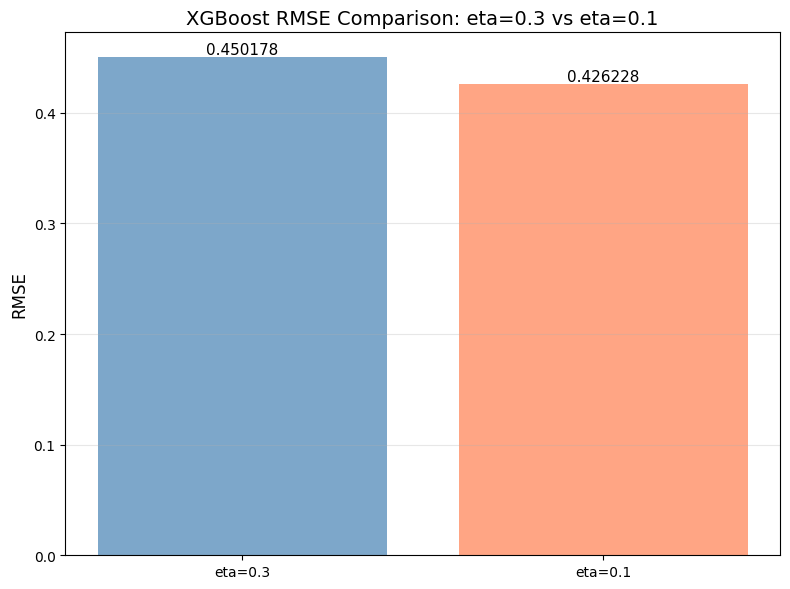

In [20]:
# Visualize the comparison
etas = [0.3, 0.1]
rmses = [rmse_03, rmse_01]

plt.figure(figsize=(8, 6))
bars = plt.bar(['eta=0.3', 'eta=0.1'], rmses, color=['steelblue', 'coral'], alpha=0.7)
plt.ylabel('RMSE', fontsize=12)
plt.title('XGBoost RMSE Comparison: eta=0.3 vs eta=0.1', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, rmse in zip(bars, rmses):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{rmse:.6f}',
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()